In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed

from graspy.models import DCSBEstimator, RDPGEstimator, SBEstimator
from graspy.plot import heatmap, pairplot
from graspy.simulations import p_from_latent, sample_edges, sbm
from graspy.utils import binarize, is_fully_connected
from graspy.simulations import sbm, sample_edges, p_from_latent
from graspy.cluster import GaussianCluster
from sklearn.mixture import GaussianMixture
from graspy.embed import AdjacencySpectralEmbed

# plotting stuff
sns.set_context("talk", font_scale=1)
plt.style.use("seaborn-white")
sns.set_palette("Set1")
savefig = False


In [6]:
def estimate_assignments(graph, n_communities, n_components=None):
    embed_graph = graph.copy()
    latent = AdjacencySpectralEmbed(
            n_components=n_components,).fit_transform(embed_graph)
    latent = np.concatenate(latent, axis=1)
    gc = GaussianCluster(min_components=n_communities,
                         max_components=n_communities)
    vertex_assignments = gc.fit_predict(latent)
    return (vertex_assignments, gc.model_._n_parameters())


def hardy_weinberg(theta):
    """
    Maps a value from [0, 1] to the hardy weinberg curve.
    """
    hw = [theta ** 2, 2 * theta * (1 - theta), (1 - theta) ** 2]
    return np.array(hw).T

def estimate_sbm(graph, n_communities, n_components=None):
    vertex_assignments, n_params = estimate_assignments(graph,
                                              n_communities,
                                              n_components)
    estimator = SBEstimator(directed=False, loops=False)
    estimator.fit(graph, y=vertex_assignments)
    return estimator, n_params

def estimate_rdpg(graph, n_components=None):
    estimator = RDPGEstimator(loops=False, n_components=n_components)
    estimator.fit(graph)
    if n_components is None: 
        n_components = estimator.latent_.shape[0]
    n_params = graph.shape[0] * n_components
    return estimator, n_params
    
def gen_hw_graph(n_verts):
    thetas = np.random.uniform(0, 1, n_verts)
    latent = hardy_weinberg(thetas)
    p_mat = p_from_latent(latent, rescale=False, loops=False)    
    graph = sample_edges(p_mat, directed=True, loops=False)
    return (graph, p_mat)

def compute_rss(estimator, graph):
    p_mat = estimator.p_mat_
    diff = (p_mat - graph)**2
    rss = np.sum(diff)
    return rss

def compute_log_lik(estimator, graph, c=0):
    p_mat = estimator.p_mat_.copy()
    graph = graph.copy()
    inds = np.triu_indices(graph.shape[0])
    p_mat = p_mat[inds]
    graph = graph[inds]
    
    p_mat[p_mat < c] = c
    p_mat[p_mat > 1 - c] = 1 - c
    successes = np.multiply(p_mat, graph)
    failures = np.multiply((1 - p_mat), (1 - graph))
    likelihood = successes + failures
    return np.sum(np.log(likelihood))

In [25]:
np.random.seed(8888)

n_sims = 50
n_verts_range = [200, 500, 1000, 1500, 2000]
n_jobs = 50
n_block_try_range = list(range(1,50))
n_components=None # for SBM embedding
n_components_try_range = list(range(1,13))


print(n_sims)
print(n_verts_range)
print(n_block_try_range)
print(n_components)
print(n_components_try_range)

def run_sim(seed):
    np.random.seed(seed)
    sbm_score = np.zeros((len(n_verts_range),
                          len(n_block_try_range)))
    sbm_n_params = np.zeros_like(sbm_score)
    sbm_rss = np.zeros_like(sbm_score)
    
    rdpg_score = np.zeros((len(n_verts_range),
                           len(n_components_try_range)))
    rdpg_n_params = np.zeros_like(rdpg_score)
    rdpg_rss = np.zeros_like(rdpg_score)
    
    for k, n_verts in enumerate((n_verts_range)):
        graph, p_mat = gen_hw_graph(n_verts)
        for l, n_block_try in enumerate(n_block_try_range):
            estimator, n_params = estimate_sbm(graph,
                                               n_block_try,
                                               n_components=n_components)

            rss = compute_rss(estimator, graph)
            score = compute_log_lik(estimator, graph)
            sbm_rss[k,l] = rss
            sbm_score[k,l] = score
            sbm_n_params[k,l] = n_params

        for l, n_components_try in enumerate(n_components_try_range):
            estimator, n_params = estimate_rdpg(graph,
                                               n_components_try)
            rss = compute_rss(estimator, graph)
            score = compute_log_lik(estimator, graph)
            rdpg_rss[k,l] = rss
            rdpg_score[k,l] = score
            rdpg_n_params[k,l] = n_params
    
    out = {'sbm':{'rss':sbm_rss,
                  'score':sbm_score,
                  'n_params':sbm_n_params}}
    out['rdpg'] = {'rss':rdpg_rss,
                   'score':rdpg_score,
                   'n_params':rdpg_n_params}
    return out

# test_out = run_si m(1)

50
[200, 500, 1000, 1500, 2000]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
None
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [26]:
seeds = np.random.randint(1e8, size=n_sims)
outs = Parallel(n_jobs=n_jobs, verbose=40)(delayed(run_sim)(seed)
                                      for seed in seeds)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   1 tasks      | elapsed: 17.7min
[Parallel(n_jobs=50)]: Done   3 out of  50 | elapsed: 20.1min remaining: 314.4min
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed: 21.7min remaining: 195.0min
[Parallel(n_jobs=50)]: Done   7 out of  50 | elapsed: 23.2min remaining: 142.3min
[Parallel(n_jobs=50)]: Done   9 out of  50 | elapsed: 23.4min remaining: 106.6min
[Parallel(n_jobs=50)]: Done  11 out of  50 | elapsed: 23.6min remaining: 83.5min
[Parallel(n_jobs=50)]: Done  13 out of  50 | elapsed: 23.9min remaining: 67.9min
[Parallel(n_jobs=50)]: Done  15 out of  50 | elapsed: 24.1min remaining: 56.2min
[Parallel(n_jobs=50)]: Done  17 out of  50 | elapsed: 24.3min remaining: 47.3min
[Parallel(n_jobs=50)]: Done  19 out of  50 | elapsed: 24.5min remaining: 39.9min
[Parallel(n_jobs=50)]: Done  21 out of  50 | elapsed: 25.2min remaining: 34.8min
[Parallel(n_jobs=50)]: Done  23 out of  50 | el

In [27]:
sbm_rss = []
sbm_score = []
sbm_n_params = []

rdpg_rss = []
rdpg_score = []
rdpg_n_params = []

for out in outs: 
    sbm_out = out['sbm']
    sbm_rss.append(sbm_out['rss'])
    sbm_score.append(sbm_out['score'])
    sbm_n_params.append(sbm_out['n_params'])
    
    rdpg_out = out['rdpg']
    rdpg_rss.append(rdpg_out['rss'])
    rdpg_score.append(rdpg_out['score'])
    rdpg_n_params.append(rdpg_out['n_params'])
    
sbm_rss = np.array(sbm_rss)
sbm_score = np.array(sbm_score)
sbm_n_params = np.array(sbm_n_params)

rdpg_rss = np.array(rdpg_rss)
rdpg_score = np.array(rdpg_score)
rdpg_n_params = np.array(rdpg_n_params)

In [28]:
rdpg_rss_mean.shape

(5, 12)

In [29]:
rdpg_rss_mean = rdpg_rss.mean(axis=0)
sbm_rss_mean = sbm_rss.mean(axis=0)
rdpg_n_params_mean = 2*rdpg_n_params.mean(axis=0)
sbm_n_params_mean = sbm_n_params.mean(axis=0)


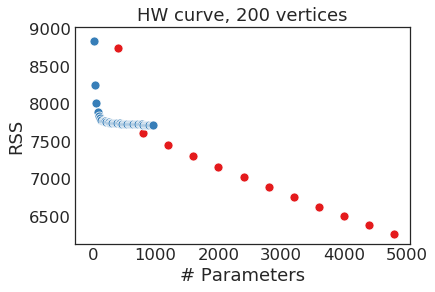

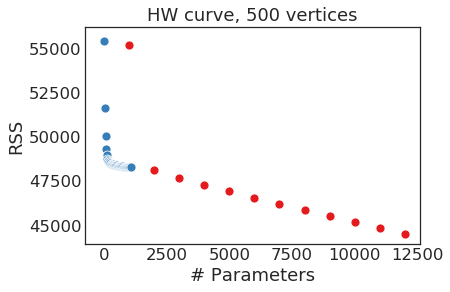

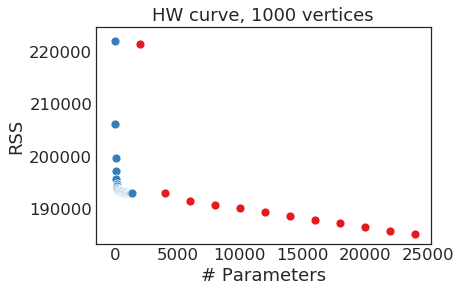

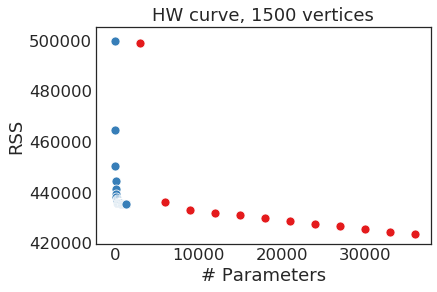

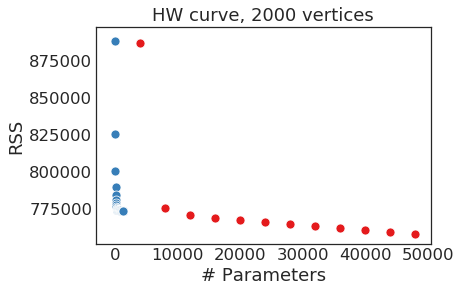

In [33]:
for i in range(5):
    plt.figure()
    sns.scatterplot(x=rdpg_n_params_mean[i], y=rdpg_rss_mean[i], )
    sns.scatterplot(x=sbm_n_params_mean[i], y=sbm_rss_mean[i])
    plt.xlabel('# Parameters')
    plt.ylabel('RSS')
    plt.title(f'HW curve, {n_verts_range[i]} vertices')

In [7]:
from graspy.utils import is_fully_connected, is_symmetric
graph, p_mat = gen_hw_graph(1000)
estimator, n_params = estimate_rdpg(graph,3)
is_symmetric(estimator.p_mat_)

False

In [8]:
for n_comp in range(20):
    estimator, n_params = estimate_rdpg(graph,n_comp)
    print(compute_rss(estimator, graph))

333049.0
221616.15351142274
192774.59824670295
191211.06251027194
190467.15422384252
189752.3191130827
189009.2076652716
188322.79785560103
187603.71004282258
186902.18962755942
186213.66492906256
185491.28824044828
184809.76419782644
184116.57433101092
183400.94042235127
182728.89138553673
182069.4827819329
181369.71072246303
180680.12949233587
180041.37588780647


In [31]:
rdpg_n_params_mean[i]

array([ 4000.,  8000., 12000., 16000., 20000., 24000., 28000., 32000.,
       36000., 40000., 44000., 48000.])